# Setup

The data consists of the daily meteorological measurements taken at Madrid Barajas Airport for 19 years, from Jan 1 1997 to Dec 31 2015 ([Kaggle source](https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv)).


The objective is to identify the best ML framework that minimizes the mean absolute error of predictions, using both univariate (purely autorgressive) and multivariate models. 

In this notebook, we explore the correlation between different forecasts (e.g. SARIMA and RNNs) and the accuracy of ensemble models.

In [599]:
import pandas as pd
import numpy as np

import math
from scipy import stats

import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

In [600]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

In [601]:
# must install statsmodels v0.12 or higher to run statsmodels.tsa.arima.model
# !pip install git+https://github.com/statsmodels/statsmodels

In [602]:
import statsmodels
statsmodels.__version__

'0.13.0.dev0+18.g3d6a49310'

In [603]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA

In [604]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

In [605]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DLA/Madrid_weather/'


Mounted at /content/drive


In [606]:
SEED=2020
np.random.seed(SEED)
tf.random.set_seed(SEED)

# EDA

In [607]:
df = pd.read_csv(path+'data/weather_madrid_clean.csv')
print(df.shape)
df.sample(5)

(4352, 10)


,date,temperature,dewpoint,humidity,pressure,visibility,windspeed,precipitation,rain,winddirection
2249,2010-03-30,10.0,4.0,68.0,1012,10.0,26,0.0,0,243
135,2004-06-15,18.0,5.0,43.0,1021,10.0,10,0.0,0,42
1052,2006-12-19,2.0,-3.0,71.0,1021,10.0,5,0.0,0,68
3677,2014-02-25,7.0,4.0,78.0,1020,17.0,13,0.0,0,219
2018,2009-08-11,24.0,11.0,48.0,1020,10.0,6,0.0,0,109


In [608]:
df.date = df.date.apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df.dtypes

date             datetime64[ns]
temperature             float64
dewpoint                float64
humidity                float64
pressure                  int64
visibility              float64
windspeed                 int64
precipitation           float64
rain                      int64
winddirection             int64
dtype: object

In [609]:
df.describe()

,temperature,dewpoint,humidity,pressure,visibility,windspeed,precipitation,rain,winddirection
count,4352.000000,4352.000000,4352.000000,4352.000000,4352.000000,4352.000000,4352.000000,4352.000000,4352.000000
mean,14.790441,4.671415,56.518382,1017.714154,12.599724,9.518382,0.174028,0.220358,200.464844
std,7.707400,4.730477,19.915857,6.548063,6.196075,5.057212,1.205556,0.414536,119.290246
min,-3.000000,-15.000000,15.000000,986.000000,1.000000,2.000000,0.000000,0.000000,1.000000
25%,8.000000,2.000000,39.000000,1014.000000,10.000000,6.000000,0.000000,0.000000,76.750000
50%,14.000000,5.000000,57.000000,1017.000000,10.000000,8.000000,0.000000,0.000000,225.000000
75%,22.000000,8.000000,73.000000,1022.000000,12.000000,11.000000,0.000000,0.000000,303.000000
max,31.000000,16.000000,99.000000,1043.000000,31.000000,39.000000,32.000000,1.000000,360.000000


In [610]:
# helper plot function
def plot_series(series_dict, start=0, t=df.date):
    """Args: 
         t, array-like of timesteps (x axis)
         series_dist, dict of {'series_name': series}
         view, optional tuple or list of (t_start, t_end)         
    """
    plt.figure(figsize=(16,6))
    for label, series in series_dict.items():
        plt.plot(t[start:], series[start:], label=label)
    plt.legend()
    plt.show()

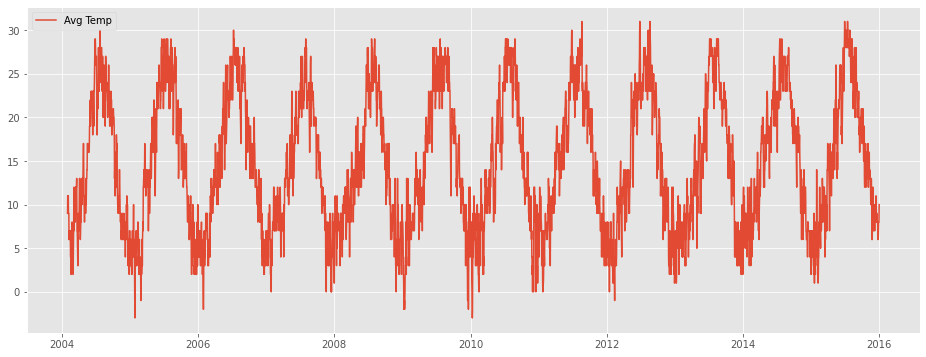

In [611]:
plot_series({'Avg Temp': df.temperature})

In [612]:
# Basic regression -  the trend is significant (~0.14 C/year)
reg = LinearRegression().fit(np.arange(len(df)).reshape(-1,1), df.temperature)
print(365*reg.coef_)

[0.13655097]


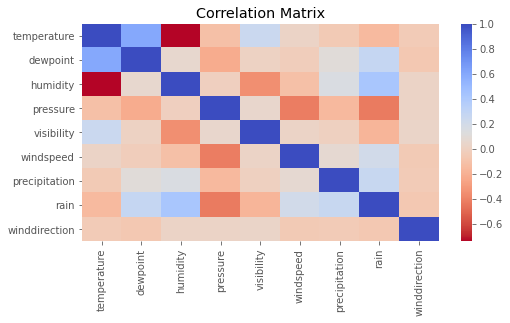

In [613]:
plt.figure(figsize=(8,4))
sns.heatmap(df.drop('date', axis=1).corr(), cmap='coolwarm_r')
plt.title('Correlation Matrix')
plt.show()

# Workflow, X,Y

The general workflow:
1. Select a single target (e.g. temperature). Do not optimize a whole vector. 
2. Decide on the metric: MAE(y_true,y_hat), but not MAPE b/c 0 degrees
3. Copy the target variable into a separate tensor Y 
4. Predictors X include the target Y.  Remove the date from X
5. Split the timeline into non-overlapping consecutive train and test. E.g. test the last 365 days of data (year 2015)
6. Leakage control: distort the last observation
7. Fit and predict 1 Horizon ahead, for both univariate and multivariate models:
    - Linear model
    - SARIMA
    - XGBoost
    - RNN
8. Explore residuals correlations, build ensemble models







In [614]:
TARGET = 'temperature'
TARGET_INDEX = list(df.columns).index(TARGET)-1  # -1 to account for the removal of the date

HORIZON = 1  # forecast horizon (e.g. for 1-day ahead forecasts, horizon=1)
VIEW_PERIOD = 90 # the last n days to visualzie y_true, y_hat

TEST_PERIOD = -3*365   # last days of the target
VAL_PERIOD = -180 # last days of the train

y_hats = []  # accumulate the forecasts


In [615]:
y = df[TARGET].values.copy()
y_true  = y[TEST_PERIOD:]   # ground truth

x = df.drop('date', axis=1).values.copy()
x_cols=df.drop('date', axis=1).columns

x[-1] *= 1e6                # distort the last timestep to detect leakage at inference time

In [616]:
def windowed_data(x,y,window_size,
                  flatten = True,
                  test_period=TEST_PERIOD,
                  val_period=VAL_PERIOD,
                  ):
    y = y[window_size:]
    x = np.array([x[s:s+window_size, :] for s in range(len(y))]) 
    if flatten: x = np.reshape(x, (len(y),-1))

    x_train, x_val, x_test = x[:test_period+val_period], x[test_period+val_period:test_period], x[test_period:]
    y_train, y_val         = y[:test_period+val_period], y[test_period+val_period:test_period]

    return x_train, x_val, x_test, y_train, y_val


In [617]:
reports = pd.DataFrame(columns=['target', 'horizon', 'forecast', 'MAE'])
reports

,target,horizon,forecast,MAE


# Benchmarks

**1. Naive**

The basic benchmark is the naive forecast S(t)=S(t-1)

In [618]:
def naive_forecast(series, test_period=TEST_PERIOD, horizon=HORIZON):
    return series[test_period-horizon : -horizon]

y_hat = naive_forecast(y)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6., 7., 8., 8., 8.])

In [619]:
model_name = 'Naive S(t)=S(t-1)'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584


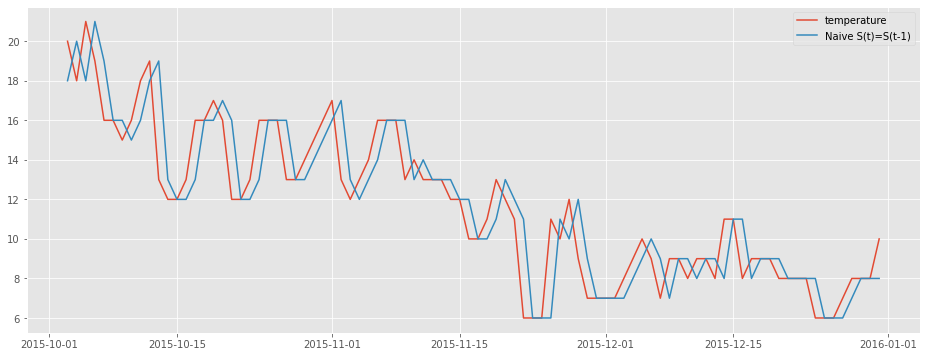

In [620]:
plot_series({f'{TARGET}': y_true,  model_name: y_hat}, -VIEW_PERIOD)

In [621]:
# check naive forecast error for n-day ahead horizons
for h in [1,2,7,30]:
    print(f'{h}   {MAE(y_true, naive_forecast(y, horizon=h)):.4f}')    

1   1.4886
2   2.0548
7   2.9014
30   4.3297


**2. Moving average differenced**

A slightly less naive approach, applicable only for periodic series, relies on smoothing the signal as compared to previous periods:  
S(t) = MA[S(t-1)-S(t-1-period)] + S(t-period)

In [622]:
def ma_trailing(series, window):
    """ Produce a trailing moving average over a fixed period length (window)
        The trailing MA does NOT include the last observation to prevent leakage
    """
    series, window = np.array(series), int(window)
    return np.array([np.nanmean(series[t-window:t]) for t in range(window, len(series))])

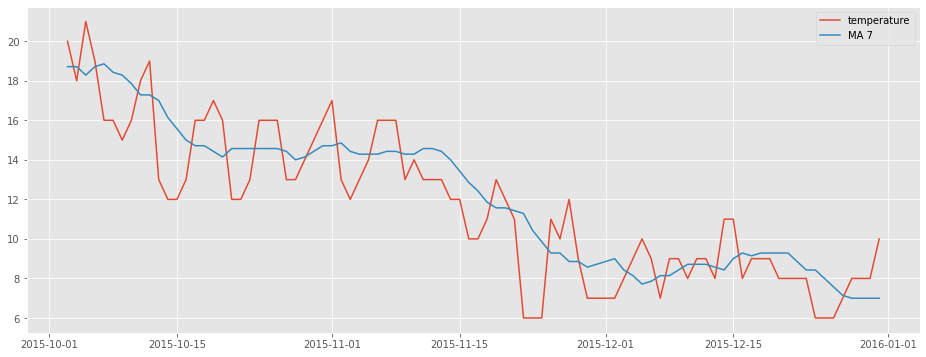

In [623]:
#e.g. weekly moving average
window = 7 
plot_series({f'{TARGET}': y_true, f'MA {window}': ma_trailing(y, window)}, -VIEW_PERIOD)

In [624]:
for w in [1,2,7,30]:
    print(w, MAE(y_true, ma_trailing(y, w)[-len(y_true):]))

1 1.4885844748858448
2 1.6703196347031963
7 2.051011089367254
30 2.6691019786910197


In [625]:
def diff_forecast(series, ma_window, period=365, split_time=TEST_PERIOD):
    """ Implements period-based  differencing: 
        S_hat(t) =  S(t-period) +  MA_ma_window [S(t)-S(t-period)]  <-- no leakage from S(t)!
        NB: works well only for strictly periodic series such as 24 hours or 365 days
    """
    diff_series = (series[period:]-series[:-period]) # S(t)-S(t-period)
    return series[split_time-period:-period] + ma_trailing(diff_series, ma_window)[split_time:]

In [626]:
# check MA differenced forecast accuracy for different MA windows
for w in range(1,10):
    print(w, MAE(y_true, diff_forecast(y, w)))    

1 2.149771689497717
2 2.367579908675799
3 2.533637747336378
4 2.624200913242009
5 2.708675799086758
6 2.7899543378995433
7 2.8331376386170906
8 2.8746575342465754
9 2.906950786402841


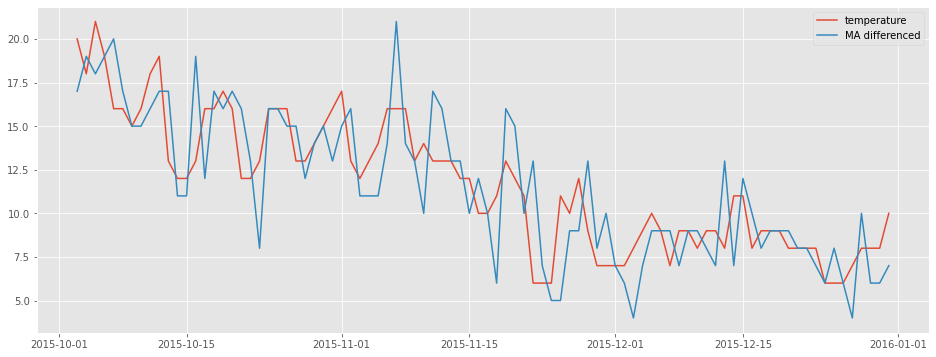

In [627]:
plot_series({f'{TARGET}': y_true,  'MA differenced': diff_forecast(y, 1)}, -VIEW_PERIOD)

Conclusion: naive forecast is more accurate than differenced

# Linear Regression 

In [628]:
for param in range(1,15):
    x_train, x_val, x_test, y_train, y_val = windowed_data(x,y,window_size=param)
    model = Ridge(alpha=1000)
    model.fit(x_train, y_train)
    y_val_hat = model.predict(x_val)
    print(param,  f'{MAE(y_val, y_val_hat):.4f}', f'{model.score(x_val, y_val):.4f}')

1 1.5911 0.9356
2 1.5338 0.9406
3 1.5427 0.9401
4 1.5329 0.9409
5 1.5282 0.9418
6 1.5143 0.9423
7 1.4823 0.9441
8 1.4856 0.9439
9 1.4885 0.9435
10 1.4945 0.9431
11 1.4945 0.9428
12 1.5275 0.9399
13 1.5403 0.9388
14 1.5365 0.9391


Best window = 7 days (although seems too large, need to explore betas)

In [629]:
WINDOW_SIZE = 7

In [630]:
x_train, x_val, x_test, y_train, y_val = windowed_data(x,y,window_size=WINDOW_SIZE)
model = Ridge(alpha=1000)
model.fit(x_train, y_train)

Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [631]:
y_hat = model.predict(x_test)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([5.74202667, 6.26025946, 7.53072339, 7.67036047, 7.53995705])

In [632]:
model_name = 'Ridge regression α=1000'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210


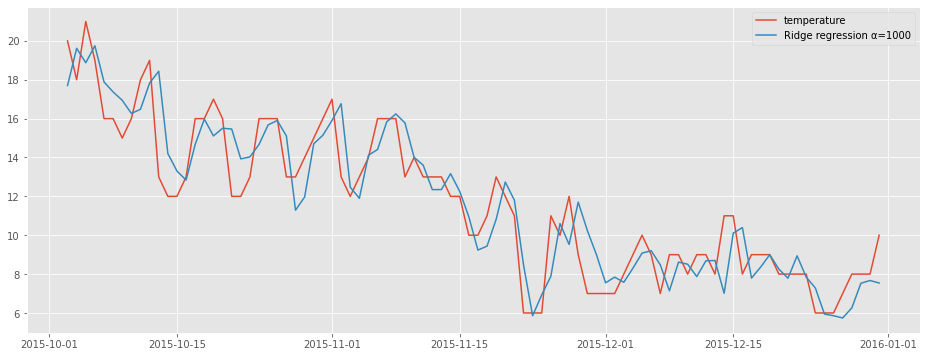

In [633]:
plot_series({f'{TARGET}': y_true,  model_name: y_hat}, -VIEW_PERIOD)

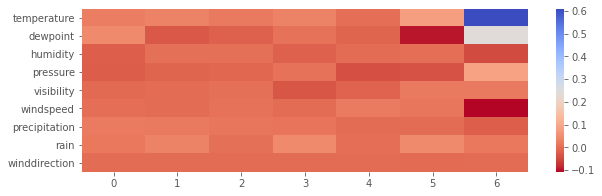

In [634]:
fi = np.reshape(model.coef_, (WINDOW_SIZE, -1))
fi = pd.DataFrame(columns=x_cols, data=fi)

plt.figure(figsize=(10,3))
sns.heatmap(fi.T, cmap='coolwarm_r')
plt.show()

In [635]:
fi.apply(sum, axis=0)

temperature      0.809165
dewpoint         0.144470
humidity        -0.062154
pressure        -0.019366
visibility       0.000105
windspeed       -0.054109
precipitation    0.053156
rain             0.169245
winddirection   -0.001294
dtype: float64

# ARIMA

In [636]:
def plot_pacf_acf(arr, max_lags):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(16, 4))
    plot_pacf(arr, lags=max_lags, ax=ax0)
    plot_acf (arr, lags=max_lags, ax=ax1)
    plt.show()

def differenced(series, period):
    return series[period:] - series[:-period]    

def plot_normal_qq(arr, title):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(16, 5))
    lim = max(np.abs(arr))
    limrange =  np.arange(-lim,lim,lim/1000)
    sns.distplot(arr, bins=min(20, len(np.unique(arr))), color='k', kde=False, norm_hist=True, ax=ax0, label='Actual')
    ax0.plot(limrange, stats.norm.pdf(limrange, np.nanmean(arr), np.nanstd(arr)), 'r', lw=1, label='Normal')
    ax0.set_title(f'{title}:  mean={np.nanmean(arr):.2f}  std={np.nanstd(arr):.2f}')
    ax0.set_xlim(-lim,lim)
    ax0.legend()
    qqplot(arr, line='q', fit=True, color='k', marker='.', ax=ax1)
    ax1.set_title(f'{title}: Q-Q plot')
    plt.show()       

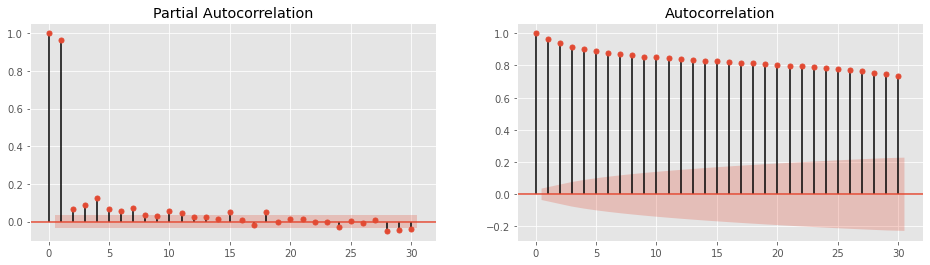

In [637]:
# PACF plot indicates an AR(~5) process
plot_pacf_acf(y_train, 30)

In [638]:
d_train = differenced(y_train, 1)
# the distribution of differences is leptokurtic -- not white noise
print(np.nanmean(d_train))
print(np.nanstd(d_train))
print(stats.skew(d_train))
print(stats.kurtosis(d_train))

0.004887585532746823
2.0151694745477955
0.03536778756634695
0.6245989429181833


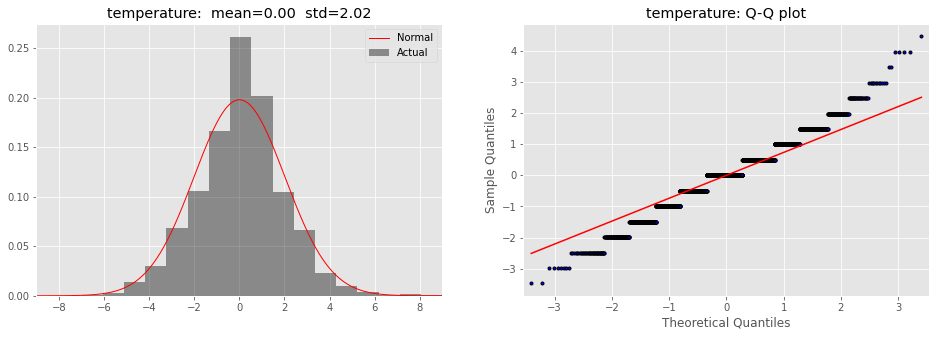

In [639]:
plot_normal_qq(d_train, title=TARGET)

In [640]:
# ARIMA: grid search of (p,d,q)
# At least 1 differencing is necessary to make the temperature series stationary
orders=[(1,1,0),
        (1,1,1),
        (2,1,0),
        (2,1,1),
        (7,1,0),        
        (7,1,1),
       ]

In [641]:
def arimax_forecast(x,y, 
               x_forecast, y_forecast, 
               order): 
            #    window_size=WINDOW_SIZE):
    model = ARIMA(y[1:TEST_PERIOD], order=order, exog=x[:TEST_PERIOD-1])
    results = model.fit()    
    extended_results = results.extend(endog=y_forecast, exog=x_forecast)
    return extended_results.forecasts[0]

In [642]:
for order in orders:
    y_val_hat = arimax_forecast(x,y, 
                           x_forecast=x[TEST_PERIOD+VAL_PERIOD-1:VAL_PERIOD-1],
                           y_forecast=y[TEST_PERIOD+VAL_PERIOD:VAL_PERIOD],
                           order=order)
    mae = MAE(y[TEST_PERIOD+VAL_PERIOD:VAL_PERIOD], y_val_hat)
    print(order, '\t', f'{mae:.4f}')

(1, 1, 0) 	 1.5378
(1, 1, 1) 	 1.5278
(2, 1, 0) 	 1.5356
(2, 1, 1) 	 1.5109
(7, 1, 0) 	 1.5067
(7, 1, 1) 	 1.5055


Best order is ARIMA(7,1,1)

In [643]:
y_hat = arimax_forecast(x,y, 
                    x_forecast=x[TEST_PERIOD-1:-1],
                    y_forecast=y[TEST_PERIOD:],
                    order=(7,1,1))
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.45573372, 6.76722161, 7.56232623, 8.15566007, 8.01025944])

In [644]:
model_name = 'ARIMAX(7,1,1)'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243


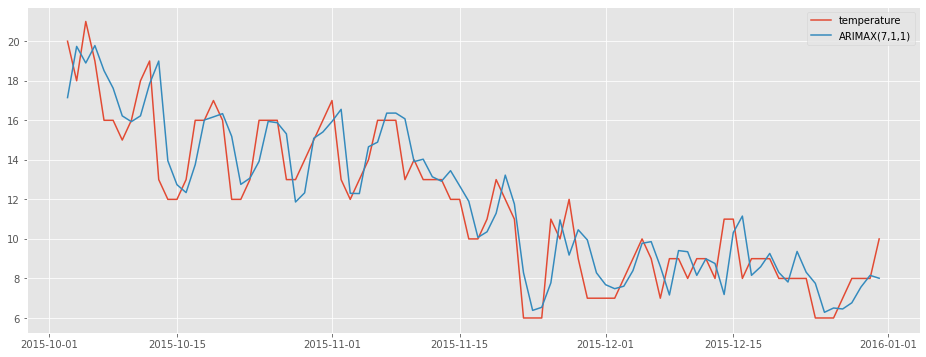

In [645]:
plot_series({f'{TARGET}': y_true,  model_name: y_hat}, -VIEW_PERIOD)

In [646]:
model = ARIMA(y[1:TEST_PERIOD], order=(7,1,1), exog=x[:TEST_PERIOD-1])
results = model.fit()
ci = results.conf_int()[:x.shape[1]]

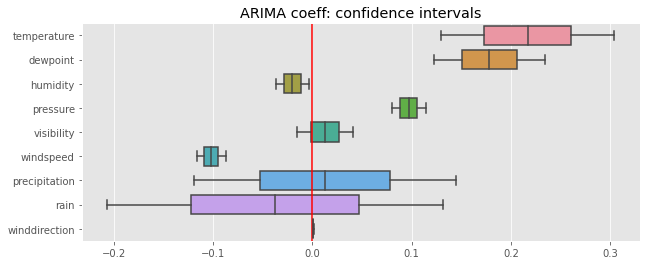

In [647]:
plt.figure(figsize=(10,4))
sns.boxplot(data=pd.DataFrame(columns=x_cols, data=ci[:9].T), orient='h')
plt.axvline(0, color='red')
plt.title('ARIMA coeff: confidence intervals')
plt.show()

# XGBoost

In [648]:
x_train, x_val, x_test, y_train, y_val = windowed_data(x,y,window_size=WINDOW_SIZE)

for param in [50, 100, 200, 500, 1000]:

    tic = time.time()
    model = XGBRegressor(objective='reg:squarederror', reg_lambda=1, n_estimators=param)
    model.fit(x_train,y_train)
    y_val_hat = model.predict(x_val)
    toc = time.time()
    
    print(f'done in {toc-tic:.1f} sec', '\t', param, '\t', f'{MAE(y_val, y_val_hat):.4f}')
   

done in 0.3 sec 	 50 	 1.4732
done in 0.5 sec 	 100 	 1.3815
done in 1.0 sec 	 200 	 1.4066
done in 2.4 sec 	 500 	 1.4359
done in 4.8 sec 	 1000 	 1.4983


The best n_estimators is the default 100 -- probably b/c of the low dimensionality of the feature space and/or linearity of the relationship

In [649]:
model = XGBRegressor(objective='reg:squarederror', reg_lambda=1, n_estimators=100)
model.fit(x_train,y_train)

y_hat = model.predict(x_test)
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.0908527, 6.351731 , 6.9212866, 8.121765 , 8.316006 ],
      dtype=float32)

In [650]:
model_name = 'XGBoost 100'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243
3,temperature,1,XGBoost 100,1.426076


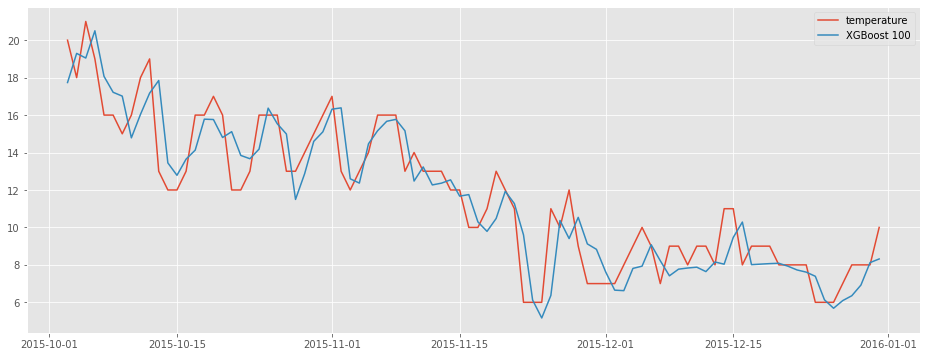

In [651]:
plot_series({f'{TARGET}': y_true,  model_name: y_hat}, -VIEW_PERIOD)

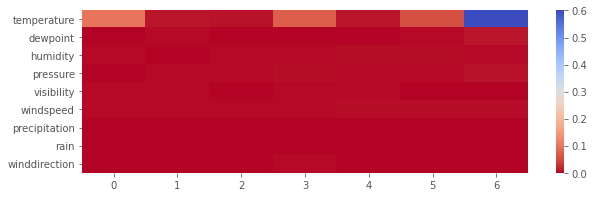

In [652]:
fi = np.reshape(model.feature_importances_, (WINDOW_SIZE,-1))
fi = pd.DataFrame(columns=x_cols, data=fi)

plt.figure(figsize=(10,3))
sns.heatmap(fi.T, cmap='coolwarm_r')
plt.show()

In [653]:
fi.apply(sum, axis=0)

temperature      0.863046
dewpoint         0.021047
humidity         0.026594
pressure         0.026483
visibility       0.016813
windspeed        0.029520
precipitation    0.000000
rain             0.002831
winddirection    0.013666
dtype: float64

Observations:
- previous day's temperature is the most influential feature by far (sanity check)
- strange pattern of -4,-7 days being more influential than -3, -6
- the model is not purely autoregressive: ~25% of tree splits along other variables

# LSTM

In [654]:
WINDOW_SIZE = 60  # small window size does not work
BATCH_SIZE  = 64
SPLIT_DS = 0.9

EPOCHS = 50
SHUFFLE_BUFFER = 1024
VERBOSE = 1

In [655]:
def rnn_dataset(series,
                target_index=TARGET_INDEX, 
                window_size=WINDOW_SIZE, 
                batch_size=BATCH_SIZE, 
                shuffle_buffer=SHUFFLE_BUFFER,
                split=SPLIT_DS,
                ):
    """Produces windowed datasets from series
       each dataset element of (X,Y) is (batch_size, window_size, features),(batch_size, window_size)
       the features dimension equals 1 for univariate series, or series.shape[1] for multivariate series
    """

    # For univariate series, add feature dimension required by TF RNNs
    if series.ndim==1: series = series[..., np.newaxis]
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)

    split = int(split*series.shape[0])
    train_ds = dataset.take(split).map(lambda w: (w[:-1], w[1:,target_index])).batch(batch_size)
    val_ds   = dataset.skip(split).map(lambda w: (w[:-1], w[1:,target_index])).batch(batch_size)

    return train_ds, val_ds

def rnn_forecast(model, 
                 series, 
                 window_size=WINDOW_SIZE, 
                 batch_size=BATCH_SIZE, 
                 ):
    
    if series.ndim==1: series = series[..., np.newaxis]

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size)
    
    return model.predict(dataset)    

def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
    flat_period, decay, floor_lr = 5, -0.1, 1e-4
    if epoch<=flat_period: 
        return lr
    return max(lr*np.exp(decay), floor_lr)
   
lr_callback=callbacks.LearningRateScheduler(scheduler, verbose=VERBOSE) 
es_callback=callbacks.EarlyStopping(monitor='val_mae', verbose=VERBOSE, patience=4, mode='min')

def plot_training(history, ylims):
    hist = history.history
    epochs = np.arange(1,1+len(hist['loss']))
    plt.figure(figsize=(10,4))
    plt.plot(epochs, hist['mae'], label='MAE train') 
    plt.plot(epochs, hist['val_mae'], label='MAE val') 
    plt.ylim(ylims)
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.show()

In [656]:
train_ds, val_ds = rnn_dataset(x[:TEST_PERIOD])
train_ds.element_spec

(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.float64, name=None))

In [657]:
model = Sequential([
    LSTM(512, input_shape=[None, x.shape[1]], return_sequences=True),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(loss='mae',
              optimizer=Adam(),
              metrics=['mae'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 512)         1069056   
_________________________________________________________________
dense_26 (Dense)             (None, None, 16)          8208      
_________________________________________________________________
dense_27 (Dense)             (None, None, 1)           17        
Total params: 1,077,281
Trainable params: 1,077,281
Non-trainable params: 0
_________________________________________________________________


In [658]:
tic = time.time()

history = model.fit(train_ds, 
                    epochs=EPOCHS,  
                    validation_data=val_ds,
                    callbacks=[lr_callback, es_callback],
                    verbose=VERBOSE)

toc = time.time()
print(f'done in {toc-tic:.1f} sec')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
46/46 [==============================] - 1s 28ms/step - loss: 8.7954 - mae: 8.7954 - val_loss: 6.7507 - val_mae: 6.7507

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
46/46 [==============================] - 1s 19ms/step - loss: 6.3845 - mae: 6.3845 - val_loss: 5.9121 - val_mae: 5.9121

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
46/46 [==============================] - 1s 19ms/step - loss: 5.2816 - mae: 5.2816 - val_loss: 4.4189 - val_mae: 4.4189

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/50
46/46 [==============================] - 1s 19ms/step - loss: 3.5578 - mae: 3.5578 - val_loss: 2.8059 - val_mae: 2.8059

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/50
46/46 [==============================] -

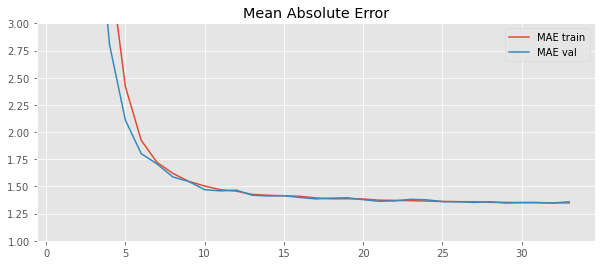

In [659]:
plot_training(history, ylims=(1,3))

In [660]:
y_hat = rnn_forecast(model, x[TEST_PERIOD-WINDOW_SIZE:-1])
y_hat = np.squeeze(y_hat[:, -1, -1])
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.491188, 6.361934, 8.045661, 8.186934, 8.291267], dtype=float32)

In [661]:
model_name = 'LSTM-512 Dense-16'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243
3,temperature,1,XGBoost 100,1.426076
4,temperature,1,LSTM-512 Dense-16,1.434378


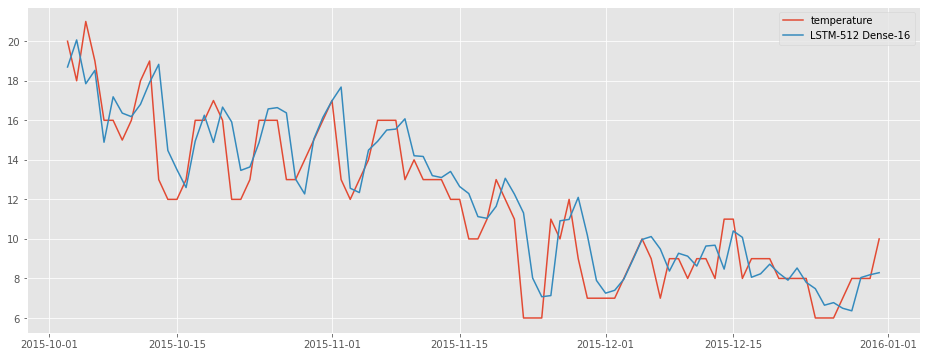

In [662]:
plot_series({f'{TARGET}': y_true, model_name: y_hat}, -VIEW_PERIOD)

# LSTM-univariate

In [663]:
train_ds, val_ds = rnn_dataset(y[:TEST_PERIOD])
train_ds.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.float64, name=None))

In [664]:
model = Sequential([
    LSTM(32, input_shape=[None, 1], return_sequences=True),
    Dense(16, activation="relu"),
    Dense(1)
])
model.compile(loss='mae',   
              optimizer=Adam(),
              metrics=['mae'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, None, 32)          4352      
_________________________________________________________________
dense_28 (Dense)             (None, None, 16)          528       
_________________________________________________________________
dense_29 (Dense)             (None, None, 1)           17        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [665]:
tic = time.time()

history = model.fit(train_ds, 
                    epochs=EPOCHS,  
                    validation_data=val_ds,
                    callbacks=[lr_callback, es_callback],
                    verbose=1)

toc = time.time()
print(f'done in {toc-tic:.1f} sec')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
46/46 [==============================] - 1s 26ms/step - loss: 13.5295 - mae: 13.5295 - val_loss: 12.1904 - val_mae: 12.1904

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
46/46 [==============================] - 1s 17ms/step - loss: 9.2854 - mae: 9.2854 - val_loss: 6.9640 - val_mae: 6.9640

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
46/46 [==============================] - 1s 18ms/step - loss: 4.7707 - mae: 4.7707 - val_loss: 3.0015 - val_mae: 3.0015

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/50
46/46 [==============================] - 1s 18ms/step - loss: 2.2567 - mae: 2.2567 - val_loss: 1.8624 - val_mae: 1.8624

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/50
46/46 [=============================

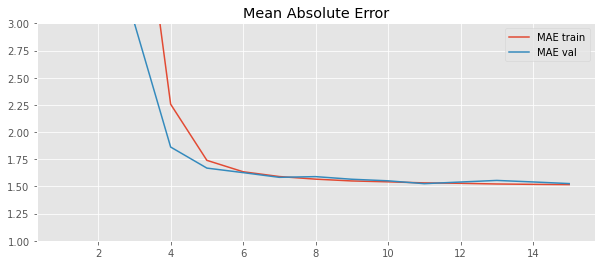

In [666]:
plot_training(history, ylims=(1,3))

In [667]:
y_hat = rnn_forecast(model, y[TEST_PERIOD-WINDOW_SIZE:-1])
y_hat = np.squeeze(y_hat[:, -1, -1])
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.151426 , 6.9468174, 7.813729 , 7.908136 , 7.919695 ],
      dtype=float32)

In [668]:
model_name = 'Uni. LSTM-32 Dense-16'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243
3,temperature,1,XGBoost 100,1.426076
4,temperature,1,LSTM-512 Dense-16,1.434378
5,temperature,1,Uni. LSTM-32 Dense-16,1.494387


The univariate RNN basically learns that the optimal forecast
 is naive:

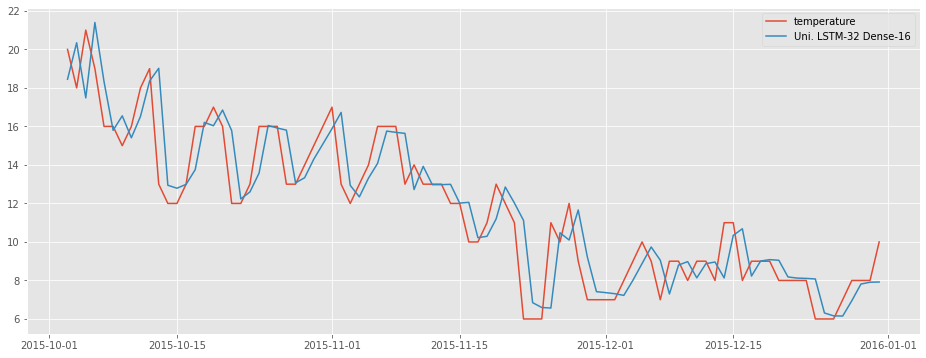

In [669]:
plot_series({f'{TARGET}': y_true, model_name: y_hat}, -VIEW_PERIOD)

# Ensembles

In [670]:
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243
3,temperature,1,XGBoost 100,1.426076
4,temperature,1,LSTM-512 Dense-16,1.434378
5,temperature,1,Uni. LSTM-32 Dense-16,1.494387


In [671]:
residuals = np.zeros((len(y_true), len(y_hats)))

for i, y_hat in enumerate(y_hats):
    residuals[:,i] =  y_hat-y_true
    
res_corr = pd.DataFrame(columns=reports.forecast, data=residuals).corr()

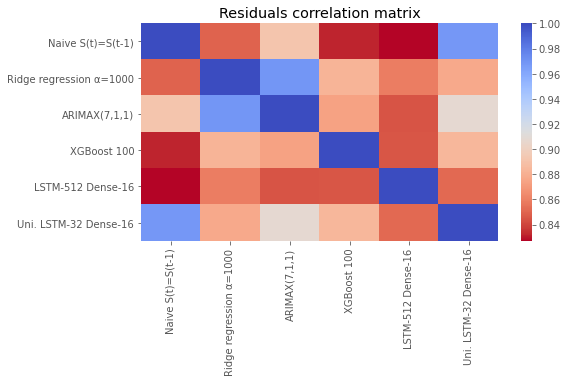

In [672]:
plt.figure(figsize=(8,4))
sns.heatmap(res_corr, cmap='coolwarm_r')
plt.title('Residuals correlation matrix')
plt.xlabel(''); plt.ylabel(''); plt.show()

Try a equally weighted ensemble of the best models: multivariate LSTM, XGBoost, ARIMA

In [673]:
y_hat = (y_hats[2]+y_hats[3]+y_hats[4])/3
y_hats.append(y_hat)
y_hat[-5:] # leakage control

array([6.34592483, 6.49362887, 7.50975793, 8.15478656, 8.20584418])

In [674]:
model_name = 'Ensemble'
reports.loc[len(reports)] = [TARGET, HORIZON, model_name, MAE(y_true, y_hat)]
reports

,target,horizon,forecast,MAE
0,temperature,1,Naive S(t)=S(t-1),1.488584
1,temperature,1,Ridge regression α=1000,1.428210
2,temperature,1,"ARIMAX(7,1,1)",1.421243
3,temperature,1,XGBoost 100,1.426076
4,temperature,1,LSTM-512 Dense-16,1.434378
5,temperature,1,Uni. LSTM-32 Dense-16,1.494387
6,temperature,1,Ensemble,1.336098


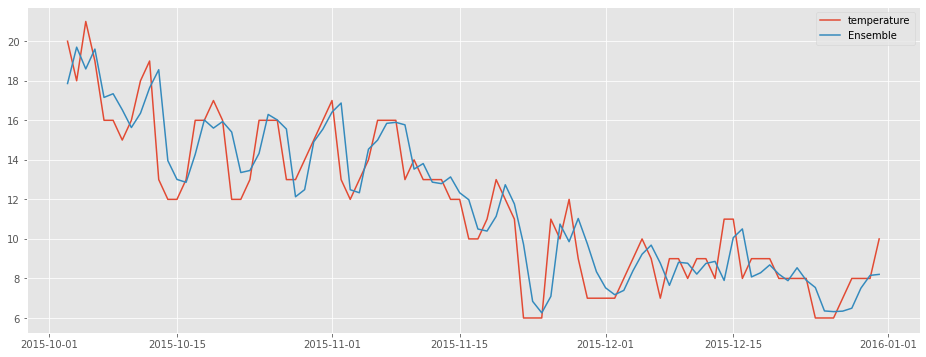

In [675]:
plot_series({f'{TARGET}': y_true, model_name: y_hat}, -VIEW_PERIOD)

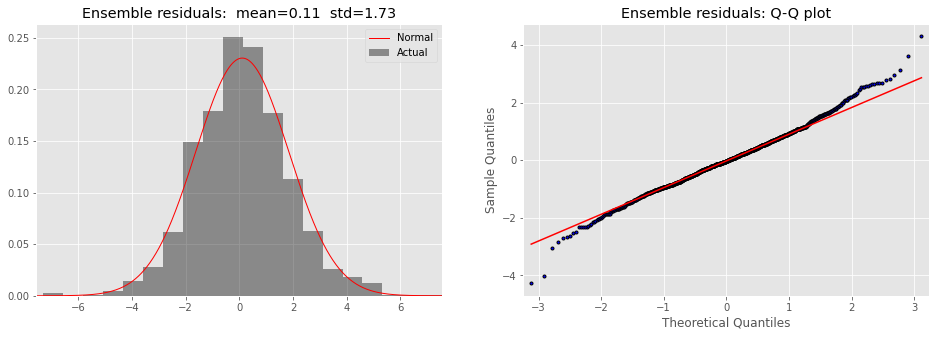

In [676]:
plot_normal_qq(y_hat-y_true, 'Ensemble residuals')

Fat tails in residuals. Large prediction errors are more likely compared to the white noise.

# Compare Models

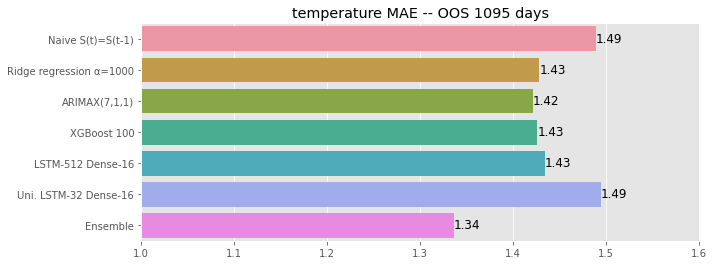

In [677]:
plt.figure(figsize=(10,4))
sns.set_palette('husl',4)
sns.barplot(reports.MAE, reports.forecast, orient='h')
for i, mae in enumerate(reports.MAE): plt.text(mae, i+0.1, f'{mae:.2f}', fontsize=12)
plt.title(f'{TARGET} MAE -- OOS {-TEST_PERIOD} days')
plt.xlim(1,1.6); plt.xlabel(''); plt.ylabel(''); plt.show()